# AdLaLa
In this notebook we will present our partitioned AdLaLa (Adaptive Langevin - Langevin) integrator for a planar spiral binary classification problem in a PyTorch framework. We shall limit ourselves to single hidden layer perceptrons in this code. More details on the AdLaLa method and other partitioned integrators for thermodynamic parameterization of neural networks can be found in our paper, which is currently available as a preprint on https://arxiv.org/abs/1908.11843

***
### Load in necessary packages

In [1]:
import numpy as np
import matplotlib.cm as cm
import numpy.random as npr
import matplotlib.pyplot as plt
import torch # version 1.0.0
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

In [2]:
print("Using torch version",torch.__version__)

Using torch version 1.0.0


***
## Data creation
The code below creates a __two-class__ spiral dataset with N datapoints, according to the equations  
\begin{align}
d1x &= a \ \text{t}^p \ \text{cos}(2 b \ \text{t}^p \ \pi) + c\mathcal{N}(0,1) \nonumber \\
d1y &= a \ \text{t}^p \ \text{sin}(2 b \ \text{t}^p\pi) + c\mathcal{N}(0,1),
\end{align}
where we typically set $a = 2$ and $p = 0.5$. Increasing $p$ has the effect of increasing the density of data points at the center of the spiral. The parameter $b$ directly sets the number of turns of the spiral and hence the complexity of the problem. We denote $b$ as `spiralturns` in the code below and $c$ as `noise`, as it controls the noise level.

The <font color=green>coordinates</font> of the 2D datapoints are loaded into <font color=green>X</font>, which has shape (N,2). <br>
The corresponding <font color=orange>labels</font> (namely whether each datapoint belongs to class A or class B) are loaded into <font color=orange>Y</font>, which is a vector with length N.

In [3]:
def twospirals(datapoints, spiralturns = 4, noise=.02, p = 0.5, a = 2):
    
    """
     Creates two spirals dataset consisting of the 2D coordinates (X) of the datapoints 
     and the corresponding labels (Y).
     The user can set the number of datapoints (N), the number of turns of the spiral (default = 4) 
     and the noise level (default = 0.02).
    """
    
    N = int(datapoints/2)  
    
    # Generate a (N,1) array with samples from the uniform distribution over [0,1)
    t = np.random.rand(N,1)
    
    # Generate noise-free training data
    d1x = a*(t**p)*np.cos(2*spiralturns*(t**p)*np.pi) 
    d1y = a*(t**p)*np.sin(2*spiralturns*(t**p)*np.pi)
    
    X = np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))) + np.random.randn( 2*N,2) * noise # Coordinates
    Y = np.hstack((np.zeros(N),np.ones(N))) # Corresponding Labels
    
    return torch.Tensor(X),torch.Tensor(Y)  # Return data + labels as torch.Tensors


Visualize the data.
- <font color=red> Class A </font> has label Y = 0. <br>
- <font color=blue> Class B </font> has label Y = 1.

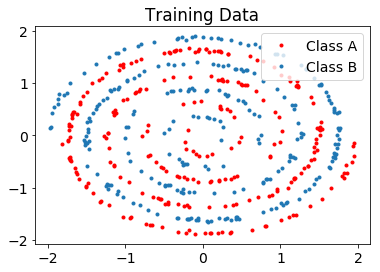

There are 500 training data points!


In [4]:
x, y = twospirals(500) 
xplot = x.detach().numpy()
yplot = y.detach().numpy()
plt.rcParams.update({'font.size': 14})
plt.title('Training Data')
plt.plot(xplot[yplot==0,0], xplot[yplot==0,1], '.', label='Class A',color='red')
plt.plot(xplot[yplot==1,0], xplot[yplot==1,1], '.', label='Class B')
plt.legend()
plt.show()
print(f'There are {x.shape[0]} training data points!')

***
### Dataloader
We now want to feed our data into PyTorch's dataloader.
This is useful for batching and shuffling our data.

In [5]:
# Prepare our data into the correct format for PyTorch's Dataloader 
class spirals(Dataset):
    
    def __init__(self,length):
        super().__init__()
        self.length = length
        self.x,self.y = twospirals(self.length)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i] 

In [6]:
Ntrain = 500                # Set the number of training data points
datanew = spirals(Ntrain)    # Generate training data points
batchsize = 25               # The batch size can be set here
dataloader = DataLoader(datanew, batch_size=batchsize, shuffle = True)  # Feed the data into the dataloader.

As you can see in the cell below, this divides the data into batches.
The shuffling occurs after each epoch.

In [7]:
for i,data in enumerate(dataloader):
    x,y = data
    print("x = ", x, ", \ny = ", y, "\n")
    if i == 1:
        print("etc...")
        break


x =  tensor([[ 7.2813e-01, -1.2249e+00],
        [ 1.1916e-01,  6.0971e-01],
        [ 7.1173e-01, -2.3633e-01],
        [-1.2806e-01,  1.6269e+00],
        [ 2.0042e+00, -1.9106e-03],
        [-9.2334e-01,  1.3538e+00],
        [-1.4681e+00,  1.3000e+00],
        [-1.4659e+00,  3.6833e-02],
        [-6.7236e-01, -1.4415e+00],
        [-9.5458e-01,  7.6522e-01],
        [-1.2760e+00, -1.4462e-01],
        [-1.5341e-01,  5.8862e-01],
        [ 1.3714e+00,  1.1955e+00],
        [ 1.0815e+00, -5.6089e-01],
        [ 1.0537e+00,  1.2002e+00],
        [-1.4957e-01,  1.3558e+00],
        [-4.8238e-01, -6.6127e-01],
        [-2.0955e-01,  6.3072e-01],
        [-1.0432e+00, -1.5186e+00],
        [ 1.1640e+00, -1.2058e+00],
        [ 1.0220e+00,  5.1469e-02],
        [ 5.4021e-01, -1.8365e+00],
        [ 1.1283e-01,  6.1055e-01],
        [ 1.9596e+00, -4.0027e-01],
        [ 6.0620e-01, -1.5424e+00]]) , 
y =  tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
      

To finalise our data. Let us also create our test dataset.

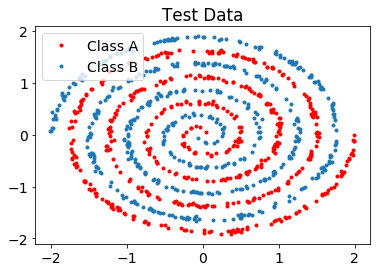

There are 1000 training data points!


In [8]:
Ntest = 1000  # Set the number of test data points
xtest,ytest = twospirals(Ntest) # Create the test data

# Visualize the test dataset
xtestplot = xtest.detach().numpy()
ytestplot = ytest.detach().numpy()
plt.rcParams.update({'font.size': 14})
plt.title('Test Data')
plt.plot(xtestplot[ytestplot==0,0], xtestplot[ytestplot==0,1], '.', label='Class A',color='red')
plt.plot(xtestplot[ytestplot==1,0], xtestplot[ytestplot==1,1], '.', label='Class B')
plt.legend()
plt.show()
print(f'There are {xtest.shape[0]} training data points!')

***
## Neural Network
Let us create a neural network with one hidden layer, consisting of 100 nodes. 

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.big_pass = nn.Sequential(nn.Linear(2,100), # Input layer (2 nodes) to hidden layer (100 nodes)
                                      nn.ReLU(),        # ReLU activation
                                      nn.Linear(100,1), # Hidden layer to output
                                      nn.Sigmoid()      # Pass output through a sigmoid 
                                                        # Sigmoid is appropriate for a binary classification problem
                                     )

    def forward(self, x):
        out = self.big_pass(x)
        return out 

Define a function to compute the accuracy

In [10]:
def accuracy_Nclass(out,y):
    diff = np.count_nonzero(np.round(out.squeeze())-y)
    return (1-(diff/np.size(y)))*100

***
## Adam 
Before we introduce our method, let us train the neural network using the well-known Adam optimizer. <br>
Relevant parameters for Adam are the timestep $h$ and the batch size. The batch size is set above when we fed the training data into the dataloader. 

In [11]:
# Parameters
h = 0.005           # Step size
num_epochs = 4000   # Number of epochs

RES = [] # Will store the results (accuracy, loss, etc..) in here
total_steps = len(dataloader)  

# Initialize the neural network
NN = Net()

# The binary cross entropy loss combined with a sigmoid, is perfectly suited for a classification problem with 2 classes
criterion = nn.BCELoss()

# Use the Adam optimiser (without regularization, but this can be easily added)
optimizer = torch.optim.Adam(NN.parameters(),lr=h) 

# If desired one can uncomment these lines to re-initialize the weights and biases. 
#for pp in NN.parameters():
#    pp.data = torch.randn(*pp.shape)

# Training
for epoch in range(num_epochs): 
    for i,data in enumerate(dataloader):

        x,y = data   # Load in data
        output = NN(x)

        loss = criterion(output,y.unsqueeze(1)) # Compute the BCE loss between the neural network's output and true labels y

        # Update the weights using backpropagation and optimization algorithm
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate how the neural network is doing and store the results
        if (epoch+1) % 10 == 0 and (i+1) % (Ntrain/batchsize) == 0:

            # Compute the accuracy of the classifier on the training data
            acc = accuracy_Nclass(output.detach().numpy(),y.detach().numpy())

            # Now look at the test data: compute loss and accuracy
            outputtest = NN(xtest)
            loss_test = criterion(outputtest,ytest.unsqueeze(1))
            acc_test = accuracy_Nclass(outputtest.detach().numpy(),ytest.detach().numpy())

            # Store values
            RES += [ [epoch , loss.item(), acc,loss_test.item(),acc_test] ]

            # Print the results every 100 epochs 
            if (epoch+1) % 100 == 0:
                print(f'epoch {epoch}/{num_epochs}, step {i+1}/{total_steps}, with test loss = {loss_test.item()}')
                print("training accuracy",acc,"% and test accuracy",acc_test,"%")

RESAdam = np.vstack(RES)

epoch 99/4000, step 20/20, with test loss = 0.6624789237976074
training accuracy 60.0 % and test accuracy 59.099999999999994 %
epoch 199/4000, step 20/20, with test loss = 0.6245809197425842
training accuracy 56.00000000000001 % and test accuracy 59.8 %
epoch 299/4000, step 20/20, with test loss = 0.5939770340919495
training accuracy 64.0 % and test accuracy 59.9 %
epoch 399/4000, step 20/20, with test loss = 0.576873779296875
training accuracy 80.0 % and test accuracy 61.9 %
epoch 499/4000, step 20/20, with test loss = 0.5819491147994995
training accuracy 80.0 % and test accuracy 63.3 %
epoch 599/4000, step 20/20, with test loss = 0.5667040348052979
training accuracy 84.0 % and test accuracy 65.5 %
epoch 699/4000, step 20/20, with test loss = 0.5590402483940125
training accuracy 80.0 % and test accuracy 64.7 %
epoch 799/4000, step 20/20, with test loss = 0.5671511888504028
training accuracy 72.0 % and test accuracy 66.39999999999999 %
epoch 899/4000, step 20/20, with test loss = 0.570

***Visualize the results***

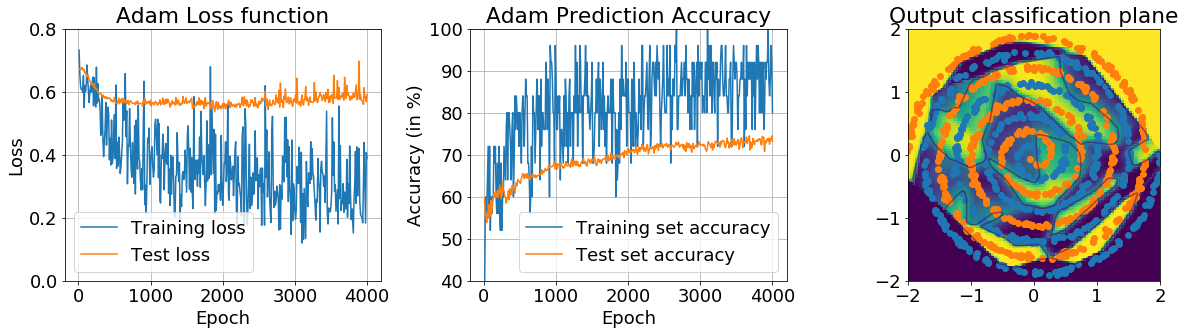

In [12]:
plt.figure(figsize=[17,5]) # Increase the size of the plots
plt.rcParams.update({'font.size': 18}) # Increase the size of the text in the plots

# Plot the training and test loss for a neural network trained using Adam
plt.subplot(1,3,1)
plt.plot( RESAdam[:,0]+1,RESAdam[:,1],label='Training loss')
plt.plot( RESAdam[:,0]+1,RESAdam[:,3],label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.ylim([0,0.8])
plt.title('Adam Loss function')
plt.tight_layout()

# Plot the accuracy of the classifier on the training and test dataset
plt.subplot(1,3,2)
plt.plot( RESAdam[:,0]+1,RESAdam[:,2],label='Training set accuracy')
plt.plot( RESAdam[:,0]+1,RESAdam[:,4],label='Test set accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (in %)')
plt.title('Adam Prediction Accuracy')
plt.grid()
plt.ylim([40,100])
plt.tight_layout()

# Plot the classification plane for the current state of the neural network
plt.subplot(1,3,3)
xx = np.linspace(-2,2,100)
X,Y = np.meshgrid(xx,xx)
Z = np.vstack([X.reshape(-1),Y.reshape(-1)])
out = NN(torch.tensor(Z.T).float())

out=out.reshape(100,100)
plt.pcolor(xx,xx,out.data)
plt.contour(xx,xx,out.data,[0.5],alpha=0.5)
plt.axis('square')

kk1 = ytest.reshape(-1)==0
kk2 = ytest.reshape(-1)==1
plt.scatter(xtest[kk1,0],xtest[kk1,1])
plt.scatter(xtest[kk2,0],xtest[kk2,1])
plt.title('Output classification plane')
#plt.tight_layout()
plt.show()

print("With hyperparameter settings:")
print("Stepize h = %g" %h)
print("Batchsize = ", batchsize)

***
## BAOAB
To understand our AdLaLa method we must first introduce our BAOAB integrator for Langevin dynamics. <br>
Consider the Langevin system
$$ \begin{align}
\text{d}\theta  &= p \ \text{d}t \\
   \text{d}p &= -\nabla L(\theta) \ \text{d}t - \gamma p \ \text{d}t+ \sqrt{2\tau \gamma} \ \text{d}W,
   \end{align}
   $$
where $\theta$ contains the neural network weights and biases. <br>
Relevant variables are: time step $h$, temperature $\tau$, and friction $\gamma$.

This system can be split into separate parts with individual updates: <br>
__A-step__ $\ \ \ \theta := \theta+h p$ <br>
__B-step__ $\ \ \ p := p-h\nabla L(\theta)$ <br>
__O-step__ $\ \ \ p := c p + d R$, with $c = e^{-\gamma h}$ and $d = \sqrt{(1-e^{-2\gamma h})\tau}$.

These updates can be combined in different orders. <br>
Here we will consider BAOAB, which is composed as: $ (\theta_{n+1},p_{n_1}) = B_{h/2} \circ A_{h/2} \circ O_{h} \circ A_{h/2} \circ B_{h/2} (\theta_n,p_n)$. <br>
Or, in practice:$ \ (\theta_{n+1},p_{n_1}) = A_{h/2} \circ O_{h} \circ A_{h/2} \circ B_{h} (\theta_n,p_n)$

***
## AdLaLa

__Adaptive Langevin (AdLa)__ <br>
Consider the system
$$ \begin{align}
\text{d}\theta  &= p \ \text{d}t \\
   \text{d}p &= -\nabla_{\theta} L(\theta) \ \text{d}t - \epsilon \xi p \ \text{d}t + \sigma \ \text{d}W_A \\
   \text{d}\xi &= \epsilon [\|p\|^2 - N \tau] \ \text{d}t
   \end{align}
   $$
Relevant variables are: <br>
time step $h$, temperature $\tau$, coupling coefficient $\epsilon$, and driving noise amplitude $\sigma$.

This system can be split into separate parts with individual updates: <br>
__A-step__ $\ \ \ \theta := \theta+h p$ <br>
__B-step__ $\ \ \ p := p-h\nabla L(\theta)$ <br>
__C-step__ $\ \ \ p := e^{-h\xi} p$ <br>
__D-step__ $\ \ \ p := p + \sigma \sqrt{h}R_n$ <br>
__E-step__ $\ \ \ \xi := \xi + h\epsilon [p^T p - N\tau]$

These updates can be combined in different orders. Here we will consider: <br>
$ \ (\theta_{n+1},p_{n_1}) = A_{h/2} \circ C_{h/2} \circ D_{h/2} \circ E_{h} \circ D_{h/2} \circ C_{h/2} \circ A_{h/2} \circ B_{h} (\theta_n,p_n)$

__Partition__ <br>
Now we will partition the neural network and apply AdLa to some layers and Langevin to the other layers. <br>
For a 2-component model this takes the form __(AdLaLa)__
$$ \begin{align}
\text{d}\theta^{(1)}  &= p^{(1)} \ \text{d}t \\
   \text{d}p^{(1)} &= -\nabla L^{(1)}(\theta) \ \text{d}t - \epsilon_1 \xi^{(1)} p^{(1)} \ \text{d}t+ \sigma \ \text{d}W^{(1)}_A \\
   \text{d}\xi^{(1)} &= \epsilon_1 [\|p^{(1)}\|^2 - N_1 \tau_1]\ \text{d}t \\
   \text{d}\theta^{(2)}  &= p^{(2)} \ \text{d}t \\
   \text{d}p^{(2)} &= -\nabla L^{(2)}(\theta) \ \text{d}t - \gamma_2 p^{(2)} \ \text{d}t + \sqrt{2 \tau_2 \gamma_2} \ \text{d}W^{(2)}_A
   \end{align}
   $$
For the Langevin system we can use BAOAB. <br>
The updates for the two components can then combined in different orders. Here we will consider:
$$\begin{align}
 (\theta_{n+1},p_{n_1}) &= A^{(1)}_{h/2} \circ A^{(2)}_{h/2}  \circ C^{(1)}_{h/2} \circ D^{(1)}_{h/2} \circ E^{(1)}_{h/2} \circ O^{(2)}_h \circ E^{(1)}_{h/2} \\
 & \ \ \circ D^{(1)}_{h/2}  \circ C^{(1)}_{h/2} \circ A^{(2)}_{h/2} \circ A^{(1)}_{h/2} \circ B^{(2)}_{h} \circ B^{(1)}_{h}
(\theta_n,p_n)
\end{align} $$

In [13]:
# Parameters
h = 0.25        # Step size / learning rate
tau1 = 1e-4     # Temperature for AdLa part (this is the first part of the partitioned system)
tau2 = 1e-4     # Temperature for Langevin (2nd part)
gamma = 0.1     # Friction parameter for Langevin part
sigma = 0.01    # Driving noise amplitude for Adaptive Langevin
N1 = 100        # Number of nodes in the hidden layer
eps = 0.05      # Coupling coefficient for Adaptive Langevin

num_epochs = 4000   # Number of epochs

RES = []            # Will store the results (accuracy, loss, etc..) in here
total_steps = len(dataloader)  

# Initialize the neural network
NN = Net()

# The binary cross entropy loss combined with a sigmoid, is perfectly suited for a classification problem with 2 classes
criterion = nn.BCELoss()

# If desired one can uncomment these lines to re-initialize the weights and biases. 
#for pp in NN.parameters():
#    pp.data = torch.randn(*pp.shape)

# Create auxiliary variables for the weights 
shapew1 = NN.big_pass[0].weight.size()
shapew2 = NN.big_pass[2].weight.size()
p_w1 = 0*torch.randn(list(shapew1))
xi_w1 = 0.01*torch.randn(list(shapew1))   # only need for first set of weights, because we only do AdL for first part of NN
p_w2 = 0*torch.randn(list(shapew2))

# Create auxiliary variables for the biases
shapeb1 = NN.big_pass[0].bias.size()
shapeb2 = NN.big_pass[2].bias.size()
p_b1 = 0*torch.randn(list(shapeb1))
xi_b1 = 0.01*torch.randn(list(shapeb1))  #only need for first set of biases, because we only do AdL for first part of NN
p_b2 = 0*torch.randn(list(shapeb2))

# Define these constants for Langevin part
c = np.exp(-h*gamma)
d = np.sqrt(1-np.exp(-2*h*gamma))*np.sqrt(tau2)

# Start training the neural network
for epoch in range(num_epochs): 
    for i,data in enumerate(dataloader):

        x,y = data  # Load in data per batch

        if i == 0 and epoch == 0:
            # Do a B_(h/2) step (p := p - 0.5*h*dL) only at the very first step 
            # After this - this will be incorporated into a B_h step at the end of each iteration)

            # To do the B_(h/2) step we need to compute dL

            output = NN(x)  # Apply the neural network to the data
            loss = criterion(output,y.unsqueeze(1)) # Compute the binary cross entropy loss between the true labels y and the NN's output

            # Compute the derivative of the loss wrt to the weights and biases of the NN
            dL1 = torch.autograd.grad(loss,NN.big_pass[0].weight,create_graph=True)[0]
            dL2 = torch.autograd.grad(loss,NN.big_pass[2].weight,create_graph=True)[0]
            dLb1 = torch.autograd.grad(loss,NN.big_pass[0].bias,create_graph=True)[0]
            dLb2 = torch.autograd.grad(loss,NN.big_pass[2].bias,create_graph=True)[0]

            # B_(h/2) step: p := p - 0.5*h*dL
            p_w1 = torch.nn.Parameter(p_w1-0.5*h*dL1)
            p_b1 = torch.nn.Parameter(p_b1-0.5*h*dLb1)
            p_w2 = torch.nn.Parameter(p_w2-0.5*h*dL2)
            p_b2 = torch.nn.Parameter(p_b2-0.5*h*dLb2)

        # A_(h/2) step: theta := theta + 0.5*h*p
        NN.big_pass[0].weight = torch.nn.Parameter(NN.big_pass[0].weight + 0.5*h*p_w1)
        NN.big_pass[2].weight = torch.nn.Parameter(NN.big_pass[2].weight + 0.5*h*p_w2)
        NN.big_pass[0].bias = torch.nn.Parameter(NN.big_pass[0].bias + 0.5*h*p_b1)
        NN.big_pass[2].bias = torch.nn.Parameter(NN.big_pass[2].bias + 0.5*h*p_b2)

        # C_(h/2) step:  p := p*exp(-0.5*h*ξ) 
        # Only for the AdLa part, i.e., the first part of the partitioning
        p_w1 = torch.nn.Parameter(p_w1*torch.exp(-0.5*h*xi_w1))  
        p_b1 = torch.nn.Parameter(p_b1*torch.exp(-0.5*h*xi_b1)) 

        # D_(h/2) step: p := p + sqrt(0.5*h)*σ*R 
        # Only for the AdLa part
        p_w1 = torch.nn.Parameter(p_w1+np.sqrt(0.5*h)*sigma*torch.randn(*shapew1))
        p_b1 = torch.nn.Parameter(p_b1+np.sqrt(0.5*h)*sigma*torch.randn(*shapeb1))

        # E_(h/2) step:  ξ := ξ + 0.5*h*ϵ*(p^T p − N*τ)
        # Only for the AdLa part
        xi_w1 = torch.nn.Parameter(xi_w1+0.5*h*eps*(torch.dot(p_w1.reshape(N1*2,1).squeeze(),p_w1.reshape(N1*2,1).squeeze())-N1*tau1))
        xi_b1 = torch.nn.Parameter(xi_b1+0.5*h*eps*(torch.dot(p_b1.reshape(N1,1).squeeze(),p_b1.reshape(N1,1).squeeze())-N1*tau1))

        # O step:  p := c*p + d*R, with c and d constants determined by gamma, h and tau_2. 
        # These constants were defined before the start of the for-loop
        # We only perform the O-step for the Langevin part, i.e., the second part of the partitioning
        p_w2 = torch.nn.Parameter(p_w2*c+d*torch.randn(*shapew2))
        p_b2 = torch.nn.Parameter(p_b2*c+d*torch.randn(*shapeb2))

        # E_(h/2) step
        xi_w1 = torch.nn.Parameter(xi_w1+0.5*h*eps*(torch.dot(p_w1.reshape(N1*2,1).squeeze(),p_w1.reshape(N1*2,1).squeeze())-N1*tau1))
        xi_b1 = torch.nn.Parameter(xi_b1+0.5*h*eps*(torch.dot(p_b1.reshape(N1,1).squeeze(),p_b1.reshape(N1,1).squeeze())-N1*tau1))

        # D_(h/2) step
        p_w1 = torch.nn.Parameter(p_w1+np.sqrt(0.5*h)*sigma*torch.randn(*shapew1))
        p_b1 = torch.nn.Parameter(p_b1+np.sqrt(0.5*h)*sigma*torch.randn(*shapeb1))

        # C_(h/2) step
        p_w1 = torch.nn.Parameter(p_w1*torch.exp(-0.5*h*xi_w1))  
        p_b1 = torch.nn.Parameter(p_b1*torch.exp(-0.5*h*xi_b1)) 

        # A_(h/2) step
        NN.big_pass[0].weight = torch.nn.Parameter(NN.big_pass[0].weight + 0.5*h*p_w1)
        NN.big_pass[2].weight = torch.nn.Parameter(NN.big_pass[2].weight + 0.5*h*p_w2)
        NN.big_pass[0].bias = torch.nn.Parameter(NN.big_pass[0].bias + 0.5*h*p_b1)
        NN.big_pass[2].bias = torch.nn.Parameter(NN.big_pass[2].bias + 0.5*h*p_b2)

        # Compute the loss
        output = NN(x)
        loss = criterion(output,y.unsqueeze(1)) 

        dL1 = torch.autograd.grad(loss,NN.big_pass[0].weight,create_graph=True)[0]
        dL2 = torch.autograd.grad(loss,NN.big_pass[2].weight,create_graph=True)[0]
        dLb1 = torch.autograd.grad(loss,NN.big_pass[0].bias,create_graph=True)[0]
        dLb2 = torch.autograd.grad(loss,NN.big_pass[2].bias)[0]

        # B step
        p_w2 = torch.nn.Parameter(p_w2-h*dL2)
        p_b2 = torch.nn.Parameter(p_b2-h*dLb2)
        p_w1 = torch.nn.Parameter(p_w1-h*dL1)
        p_b1 = torch.nn.Parameter(p_b1-h*dLb1)

        # Evaluate how the neural network is doing and store the results
        if (epoch+1) % 10 == 0 and (i+1) % (Ntrain/batchsize) == 0:

            # Compute the accuracy of the classifier on the training data
            acc = accuracy_Nclass(output.detach().numpy(),y.detach().numpy())

            # Now look at the test data: compute loss and accuracy
            outputtest = NN(xtest)
            loss_test = criterion(outputtest,ytest.unsqueeze(1))
            acc_test = accuracy_Nclass(outputtest.detach().numpy(),ytest.detach().numpy())

            # Store values
            RES += [ [epoch , loss.item(), acc,loss_test.item(),acc_test] ]

            # Print the results every 100 epochs
            if (epoch+1) % 100 == 0:
                print(f'epoch {epoch}/{num_epochs}, step {i+1}/{total_steps}, with test loss = {loss_test.item()}')
                print("Training accuracy",acc,"% and test accuracy",acc_test,"%")

RESAdLaLa = np.vstack(RES)

With hyperparameter settings:
Stepize h = 0.005
Batchsize =  25
epoch 99/4000, step 20/20, with test loss = 0.6114405989646912
Training accuracy 60.0 % and test accuracy 60.5 %
epoch 199/4000, step 20/20, with test loss = 0.5715568661689758
Training accuracy 72.0 % and test accuracy 64.4 %
epoch 299/4000, step 20/20, with test loss = 0.5313287973403931
Training accuracy 64.0 % and test accuracy 68.19999999999999 %
epoch 399/4000, step 20/20, with test loss = 0.5264026522636414
Training accuracy 84.0 % and test accuracy 69.30000000000001 %
epoch 499/4000, step 20/20, with test loss = 0.523045003414154
Training accuracy 84.0 % and test accuracy 72.3 %
epoch 599/4000, step 20/20, with test loss = 0.4777411222457886
Training accuracy 88.0 % and test accuracy 71.50000000000001 %
epoch 699/4000, step 20/20, with test loss = 0.46295085549354553
Training accuracy 88.0 % and test accuracy 73.4 %
epoch 799/4000, step 20/20, with test loss = 0.4387347102165222
Training accuracy 76.0 % and test ac

***Visualize the results***

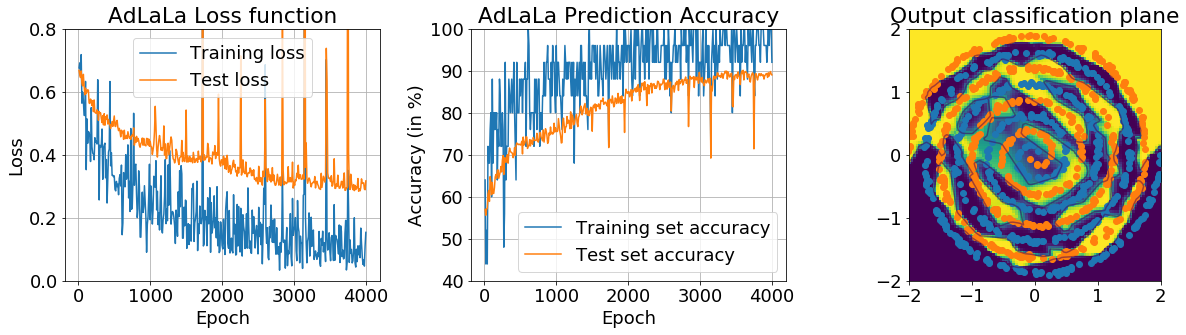

With hyperparameter settings:
Stepize h = 0.25
tau1 = 0, tau2 = 0
gamma = 0.1
sigma = 0.01
eps = 0.05
N1 = 100


In [14]:
plt.figure(figsize=[17,5]) # Increase the size of the plots
plt.rcParams.update({'font.size': 18}) # Increase the size of the text in the plots

# Plot the training and test loss
plt.subplot(1,3,1)
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,1],label='Training loss')
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,3],label='Test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.ylim([0,0.8])
plt.title('AdLaLa Loss function')
plt.tight_layout()

# Plot the accuracy of the classifier on the training and test dataset
plt.subplot(1,3,2)
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,2],label='Training set accuracy')
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,4],label='Test set accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (in %)')
plt.title('AdLaLa Prediction Accuracy')
plt.grid()
plt.ylim([40,100])
plt.tight_layout()

# Plot the classification plane for the current state of the neural network NN
plt.subplot(1,3,3)
xx = np.linspace(-2,2,100)
X,Y = np.meshgrid(xx,xx)
Z = np.vstack([X.reshape(-1),Y.reshape(-1)])
out = NN(torch.tensor(Z.T).float())

out=out.reshape(100,100)
plt.pcolor(xx,xx,out.data)
plt.contour(xx,xx,out.data,[0.5],alpha=0.5)
plt.axis('square')

kk1 = ytest.reshape(-1)==0
kk2 = ytest.reshape(-1)==1
plt.scatter(xtest[kk1,0],xtest[kk1,1])
plt.scatter(xtest[kk2,0],xtest[kk2,1])
plt.title('Output classification plane')
plt.tight_layout()
plt.show()

print("With hyperparameter settings:")
print("Stepize h = %g" %h)
print("tau1 = %i, tau2 = %i" %(tau1,tau2))
print("gamma = %g" %gamma)
print("sigma = %g" %sigma)
print("eps = %g" %eps)
print("N1 = %i" %N1)


---
***Compare Performance Adam and AdLaLa***

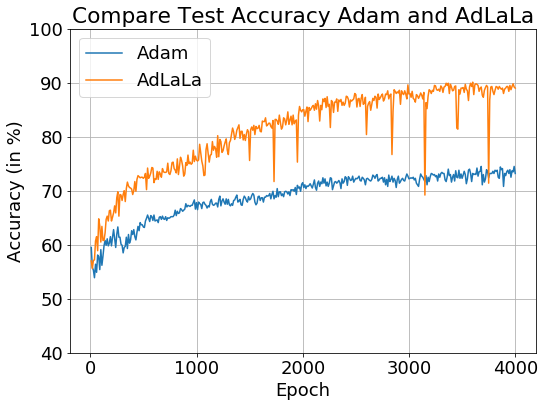

In [15]:
plt.figure(figsize=[8,6])
plt.rcParams.update({'font.size': 18})
# Plot the test loss

# Plot the accuracy of a neural network trained using Adam vs. AdLaLa on the test dataset
plt.plot( RESAdam[:,0],RESAdam[:,4],label='Adam')
plt.plot( RESAdLaLa[:,0],RESAdLaLa[:,4],label='AdLaLa')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy (in %)')
plt.title('Compare Test Accuracy Adam and AdLaLa')
plt.grid()
plt.ylim([40,100])
plt.tight_layout()

